#### Riding bikes (bicycles) have been a longstanding method of transportation for fitness enthusiasts, environmentalists, students, hikers etc. We were intrigued by the dataset and its in-depth record of trip analysis for bikers in NYC. Even though NYC is a city where the major mode of transportation for most people would be cars or public transport, the data presented for bikers is in itself really interesting. By analysing and understanding data related to cycling, we can gain insights into factors that impact cycling behavior, such as weather, infrastructure, and demographics. Additionally, bicycle data can be used to inform policy decisions and planning efforts aimed at promoting cycling and creating safer cycling environments. Working with a bicycle riding dataset can help us better understand this important mode of transportation and recreation.

# NYC Biking & Weather Analysis
### The following datasets have been used for the analysis and their EDA is provided through the notebook
####
1. NYC Citi Bikes dataset (https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-citi-bike)
2. Storms information (https://console.cloud.google.com/marketplace/product/noaa-public/severe-storm-events)
3. Extreme weather datasets (https://console.cloud.google.com/marketplace/product/noaa-public/preliminary-storm-reports)
4. NYC 311 Calls Dataset (https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=new_york_311&page=dataset&project=is-843-project-t4)
5. NYC weather dataset(https://github.com/zonination/weather-us)
### Through this analysis we will be answering the following questions 

#### 
1. Given the bike rides dataset and weather dataset let us analyse the co-relation between temperatures of the day with the number of bikes rented (The analysis is performed on hot/cold weather conditions as compared to pleasant weather conditions)
2. Given the storm dataset and bike rides dataset perform an analysis on the effect of harsh stormy weather conditions on bikes being rented (Keep in mind outliers by performing box selection of only area of NYC)
3. Given the bikes dataset and 311 calls dataset perform an analysis on Relation between Safety/Traffic issue calls on the rental of bikes. Perform this analysis in the form of designing scatter plots to analyse weather there is a change in rentals in areas having higher concerns.
4. Given the bikes dataset and 311 calls dataset analyse if on months having more number of safety/traffic concerns were the number of bike rentals co-related to the same or not? (Please note that accuracy of this question comes into question as the analysis is solely being done on a monthly agregate basis without bringing into question accurate location information and only as a collective. For future goals the analysis can be done on a simple location basis)
5. Perform an analysis on the bikes dataset to find out which station ids were most or least popular through different days.
6. Given the bikes dataset and the extreme weathers dataset form an analysis on the question "do drops in bike rentals correspond to reported bad weather events?"

### Special Thanks to:
1. City of New York and Google for providing the datasets used for this analysis
2. ChatGPT and Open AI team for providing us with helpful resources and quick resolutions to problems we are stuck with. ChatGPT was only used to know about how certain logics could be performed especially in sections of scatter plots and line charts to overlay images
3. Stackoverflows.com

##### The above are to be considered as the resources we used

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DateType, 
                               BooleanType,
                               DoubleType,
                               IntegerType,
                               StringType,
                               LongType,
                               FloatType,
                              TimestampType)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')
data = "gs://is-843-t4/notebooks/jupyter/data/"

***
# Section 1
### Conducting a relative study between the storm dataset and NYC Citi bikes dataset to analyse whether storms and other events lead to a specific change in bike rental industry
***

## Analysing the NYC Bikes dataset and NYC Temperatures dataset to answer the following question
#### Question: What is the co-relation between temperature and bikes rented by users
#### Expected Answer: Lesser bikes would be rented during colder or very hot temperatures as compared to a pleasent weather

In [3]:
nyc_temp = spark.read.format("csv").option("header", "true").load(data + "nyc.csv")
nyc_bikes = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_citibike.citibike_trips').load()

In [3]:
nyc_bikes.printSchema()
nyc_bikes.count()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: string (nullable = true)
 |-- stoptime: string (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: long (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bikeid: long (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- customer_plan: string (nullable = true)



58937715

In [4]:
nyc_temp.printSchema()
nyc_temp.count()

root
 |-- _c0: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Max.TemperatureF: string (nullable = true)
 |-- Mean.TemperatureF: string (nullable = true)
 |-- Min.TemperatureF: string (nullable = true)
 |-- Max.Dew.PointF: string (nullable = true)
 |-- MeanDew.PointF: string (nullable = true)
 |-- Min.DewpointF: string (nullable = true)
 |-- Max.Humidity: string (nullable = true)
 |-- Mean.Humidity: string (nullable = true)
 |-- Min.Humidity: string (nullable = true)
 |-- Max.Sea.Level.PressureIn: string (nullable = true)
 |-- Mean.Sea.Level.PressureIn: string (nullable = true)
 |-- Min.Sea.Level.PressureIn: string (nullable = true)
 |-- Max.VisibilityMiles: string (nullable = true)
 |-- Mean.VisibilityMiles: string (nullable = true)
 |-- Min.VisibilityMiles: string (nullable = true)
 |-- Max.Wind.SpeedMPH: string (nullable = true)
 |-- Mean.Wind.SpeedMPH: string (nullable = true)
 |-- Max.Gust.SpeedMPH: string (nullable = true)
 |-- PrecipitationIn: string (nullable

24560

In [5]:
nyc_mean_temp = nyc_temp.select(['Date','`Mean.TemperatureF`'])

In [6]:
nyc_mean_temp = nyc_mean_temp.withColumn("mean_temp", F.col("`Mean.TemperatureF`").cast(LongType()))
nyc_mean_temp = nyc_mean_temp.withColumn("Date", F.col("Date").cast(DateType()))
nyc_mean_temp = nyc_mean_temp.select('Date','mean_temp')
nyc_mean_temp = nyc_mean_temp.na.drop('any')

In [7]:
nyc_mean_temp.cache()
nyc_mean_temp.count()

24558

In [8]:
nyc_bikes = nyc_bikes.withColumn("tripduration", F.col("tripduration").cast(IntegerType()))
nyc_bikes = nyc_bikes.withColumn("starttime", F.col("starttime").cast("timestamp"))
nyc_bikes = nyc_bikes.withColumn("stoptime", F.col("stoptime").cast("timestamp"))

In [9]:
nyc_bikes.limit(3).show()
nyc_bikes.printSchema()

+------------+---------+--------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---------------------+------+--------+----------+------+-------------+
|tripduration|starttime|stoptime|start_station_id|start_station_name|start_station_latitude|start_station_longitude|end_station_id|end_station_name|end_station_latitude|end_station_longitude|bikeid|usertype|birth_year|gender|customer_plan|
+------------+---------+--------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---------------------+------+--------+----------+------+-------------+
|        null|     null|    null|            null|                  |                  null|                   null|          null|                |                null|                 null|  null|        |      null|      |             |
|        null|     null|    null|       

|Column Name|Description|Type|
|--|--|--|
|Date|the date with a format 'yyyy-mm-dd' |datetype|
|mean_temp|the average temperature of a specific date|Long|

|Column Name|Description|Type|
|--|--|--|
|tripduration|the riding time for each events in second|Integer|
|starttime|Timestamp of the starting time of the riding events|Timestamp|
|stoptime|Timestamp of the ending time of the riding events|Timestamp|



In [10]:
trip_duration = nyc_bikes.groupBy(F.year('starttime').alias('year'),F.month('starttime').alias('month'))\
                .agg(F.sum('tripduration').alias('total_trip_duration'))

In [11]:
days_in_month = nyc_bikes.groupBy(F.year('starttime').alias('year'),F.month('starttime').alias('month'))\
                .agg(F.countDistinct(F.dayofmonth('starttime')).alias('days_in_month'))

In [12]:
trip_duration_per_day = trip_duration.join(days_in_month, ['year','month']) \
                        .select('year','month', (F.col('total_trip_duration') / F.col('days_in_month')).alias('total_duration_per_day'))\
                        .orderBy('year','month').sort('year','month',ascending = True,descending = False)

In [13]:
nyc_monthly_mean_temp = nyc_mean_temp.groupBy(F.year('Date').alias('year'),F.month('Date').alias('month'))\
                                .agg(F.mean('mean_temp').alias('monthly_mean_temp'))

In [14]:
trip_temp = trip_duration_per_day.join(nyc_monthly_mean_temp, ['year','month'])\
            .orderBy('year','month').sort('year','month',ascending = True,descending = False)

In [15]:
pd_trip_temp = trip_temp.toPandas()

In [16]:
#convert seconds to hours
pd_trip_temp['total_duration_per_day'] = pd_trip_temp['total_duration_per_day']/60/60

In [25]:
print(pd_trip_temp[:3])

   year  month  total_duration_per_day  monthly_mean_temp
0  2013      7             7543.137124          79.677419
1  2013      8             8794.787142          74.612903
2  2013      9             8667.742398          67.266667


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd

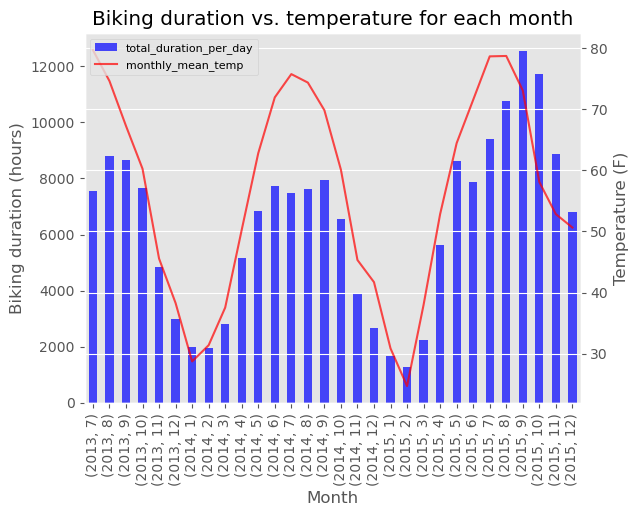

In [27]:
df = pd_trip_temp.set_index(['year','month'])
ax1 = df['total_duration_per_day'].plot(kind='bar', color='b', alpha=0.7)
ax2 = df['monthly_mean_temp'].plot(kind= 'line',secondary_y=True, color='r', alpha=0.7)

ax1.set_ylabel('Biking duration (hours)')
ax2.set_ylabel('Temperature (F)')
ax1.set_xlabel('Month')
plt.title('Biking duration vs. temperature for each month')

xticklabels = [str(x)[:len(str(x))] for x in df.index]
ax1.set_xticklabels(xticklabels, rotation='vertical')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.show()

##### From the above analysis you can see that our previous expectation was correct, people tend to prefer to take bikes during a much more pleasant weather as compared to any other season (Winters or high summbers)

## Biking duration prediction though linear regression

In [35]:
trip_duration_date = nyc_bikes.withColumn("date", F.date_format(F.col("starttime"), "yyyy-MM-dd"))
avg_duration = trip_duration_date.groupBy("date").agg(F.avg(F.col("tripduration")).alias('avg_duration'))
nyc_weather = nyc_temp
nyc_weather = nyc_weather.select(['Date','`Mean.TemperatureF`','`Max.TemperatureF`','`Min.TemperatureF`','`Max.Humidity`','`Mean.Humidity`','`Min.Humidity`','`Mean.VisibilityMiles`','`Max.VisibilityMiles`','`Min.VisibilityMiles`','`Mean.Wind.SpeedMPH`','`PrecipitationIn`'])

In [36]:
nyc_weather = nyc_weather.withColumn("mean_temp", F.col("`Mean.TemperatureF`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("Date", F.col("Date").cast(DateType()))
nyc_weather = nyc_weather.withColumn("max_temp", F.col("`Max.TemperatureF`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("min_temp", F.col("`Min.TemperatureF`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("mean_humi", F.col("`Mean.Humidity`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("max_humi", F.col("`Max.Humidity`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("min_humi", F.col("`Min.Humidity`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("mean_vis", F.col("`Mean.VisibilityMiles`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("max_vis", F.col("`Max.VisibilityMiles`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("min_vis", F.col("`Min.VisibilityMiles`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("mean_wind", F.col("`Mean.Wind.SpeedMPH`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("preci", F.col("`PrecipitationIn`").cast(LongType()))
nyc_weather = nyc_weather.withColumn("diff_temp", F.col("max_temp") - F.col("min_temp"))
nyc_weather = nyc_weather.withColumn("diff_humi", F.col("max_humi") - F.col("min_humi"))
nyc_weather = nyc_weather.withColumn("diff_vis", F.col("max_vis") - F.col("min_vis"))
nyc_weather = nyc_weather.select(["Date","mean_temp","diff_temp","mean_humi","diff_humi","mean_vis","diff_vis","mean_wind","preci"])
nyc_weather = nyc_weather.na.drop('any')

In [37]:
nyc_weather_trip = avg_duration.join(nyc_weather, 'date').orderBy('date').sort('date', ascending = True)
nyc_weather_trip.show(3)

+----------+-----------------+---------+---------+---------+---------+--------+--------+---------+-----+
|      date|     avg_duration|mean_temp|diff_temp|mean_humi|diff_humi|mean_vis|diff_vis|mean_wind|preci|
+----------+-----------------+---------+---------+---------+---------+--------+--------+---------+-----+
|2013-07-01|978.5992792792792|       75|        7|       91|        7|       5|      10|       11|    0|
|2013-07-02|958.1295669377886|       75|        8|       85|       17|       6|      10|       12|    0|
|2013-07-03|974.3284851811196|       76|       11|       86|       23|      10|       4|       10|    0|
+----------+-----------------+---------+---------+---------+---------+--------+--------+---------+-----+
only showing top 3 rows



In [38]:
from pyspark.ml.feature import VectorAssembler
nyc_weather_trip = nyc_weather_trip.drop('date')
train, test = nyc_weather_trip.randomSplit([0.7, 0.3], seed = 8)
input_cols = ['mean_temp', 'diff_temp', 'mean_humi', 'diff_humi', 'mean_vis', 'diff_vis', 'mean_wind', 'preci']
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [39]:
from pyspark.ml.regression import LinearRegression
regression = LinearRegression(labelCol = 'avg_duration', regParam =1, elasticNetParam=1).fit(train)
predictions = regression.transform(test)

23/04/30 20:10:17 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/30 20:10:17 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [40]:
from pyspark.ml.evaluation import RegressionEvaluator
rmse = RegressionEvaluator(labelCol='avg_duration').evaluate(predictions)
print("The test RMSE is", rmse)

The test RMSE is 324.77651083235105


In [47]:
import matplotlib.pyplot as plt

predictions_df = regression.transform(test).select('prediction', 'avg_duration')
predictions = predictions_df.rdd.map(lambda row: (row[0], row[1])).collect()

x = [row[1] for row in predictions]
y = [row[0] for row in predictions]

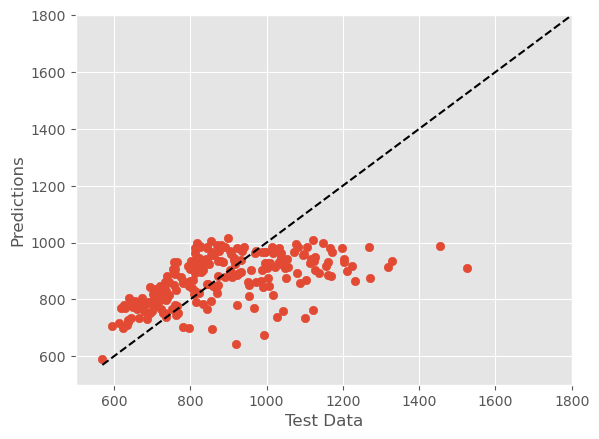

In [48]:
plt.scatter(x, y)
plt.plot([min(x), max(x)], [min(x), max(x)], 'k--')
plt.xlabel('Test Data')
plt.ylabel('Predictions')
plt.xlim([500, 1800])
plt.ylim([500, 1800])
plt.show()

#### We use the selected weather features in a day to predict the average biking duration of the day
#### The dotted line represents the accurate data, indicating that the prediction model may not performe well

## Biking Behavior vs. Weather Conditions

In [103]:
total_duration = trip_duration_date.groupBy("date").agg(F.sum(F.col("tripduration")).alias('total_duration'))
total_duration = total_duration.join(avg_duration,"date")
total_duration.cache()
total_duration.show(3)

+----------+--------------+------------------+
|      date|total_duration|      avg_duration|
+----------+--------------+------------------+
|2014-02-16|       3846266|1280.8078588078588|
|2014-02-22|      12891153| 988.2821987120515|
|2014-05-27|      28496378| 865.2045785766335|
+----------+--------------+------------------+
only showing top 3 rows



In [104]:
total_duration_temp = total_duration.join(nyc_mean_temp,'date').orderBy('date').sort('date', ascending = True)
total_duration_temp.show(3)

+----------+--------------+-----------------+---------+
|      date|total_duration|     avg_duration|mean_temp|
+----------+--------------+-----------------+---------+
|2013-07-01|      16293678|978.5992792792792|       75|
|2013-07-02|      21792657|958.1295669377886|       75|
|2013-07-03|      21302718|974.3284851811196|       76|
+----------+--------------+-----------------+---------+
only showing top 3 rows



In [105]:
from pyspark.sql.functions import when

freezing_threshold = 32
cold_threshold = 50
cool_threshold = 65
warm_threshold = 77
hot_threshold = 85

categorized_temps = total_duration_temp.withColumn('category', 
                        when(nyc_mean_temp['mean_temp'] < freezing_threshold, 'freezing')
                       .when(nyc_mean_temp['mean_temp'] < cold_threshold, 'cold')
                       .when(nyc_mean_temp['mean_temp'] < cool_threshold, 'cool')
                       .when(nyc_mean_temp['mean_temp'] < warm_threshold, 'warm')
                       .when(nyc_mean_temp['mean_temp'] < hot_threshold, 'hot')
                       .otherwise('scorching'))

categorized_temps.cache()
categorized_temps.show(3)

+----------+--------------+-----------------+---------+--------+
|      date|total_duration|     avg_duration|mean_temp|category|
+----------+--------------+-----------------+---------+--------+
|2013-07-01|      16293678|978.5992792792792|       75|    warm|
|2013-07-02|      21792657|958.1295669377886|       75|    warm|
|2013-07-03|      21302718|974.3284851811196|       76|    warm|
+----------+--------------+-----------------+---------+--------+
only showing top 3 rows



In [106]:
categorized_temps1 = categorized_temps.groupby('category').agg(F.avg(F.col("avg_duration")).alias('avg_duration'))
categorized_temps2 = categorized_temps.groupby('category').agg(F.sum(F.col("total_duration")).alias('total_duration'))
categorized_temps = categorized_temps1.join(categorized_temps2,'category')
categorized_temps = categorized_temps.withColumn('id', when(categorized_temps['category'] == 'freezing', 1)
                                                 .when(categorized_temps['category'] == 'cold', 2)
                                                 .when(categorized_temps['category'] == 'cool', 3)
                                                 .when(categorized_temps['category'] == 'warm', 4)
                                                 .when(categorized_temps['category'] == 'hot', 5)
                                                 .when(categorized_temps['category'] == 'scorching', 6))
categorized_temps = categorized_temps.orderBy('id').sort('id',ascending = True)
categorized_temps.show()

+---------+-----------------+--------------+---+
| category|     avg_duration|total_duration| id|
+---------+-----------------+--------------+---+
| freezing|773.7413332302598|     583959730|  1|
|     cold|780.3820681091083|    2931436824|  2|
|     cool|921.2662737969107|    6290197869|  3|
|     warm|955.9668098288095|    7221505563|  4|
|      hot|953.1742953151775|    3724244301|  5|
|scorching|906.3980452565708|     219210401|  6|
+---------+-----------------+--------------+---+



In [107]:
pd_categorized_temps = categorized_temps.toPandas()

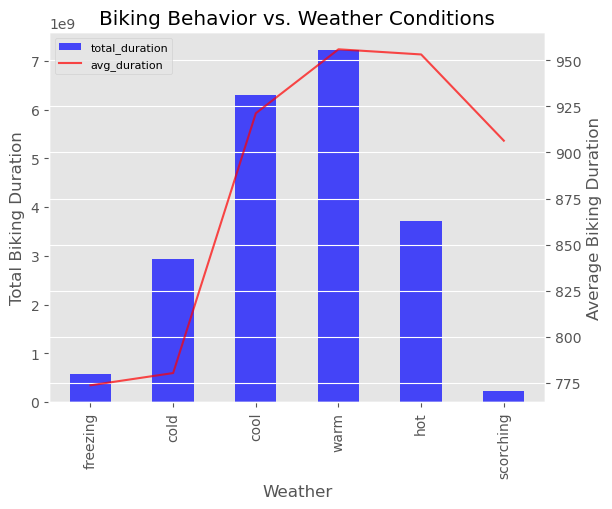

In [108]:
df = pd_categorized_temps.set_index('category')
ax1 = df['total_duration'].plot(kind='bar', color='b', alpha=0.7)
ax2 = df['avg_duration'].plot(kind= 'line',secondary_y=True, color='r', alpha=0.7)

ax1.set_ylabel('Total Biking Duration')
ax2.set_ylabel('Average Biking Duration')
ax1.set_xlabel('Weather')
plt.title('Biking Behavior vs. Weather Conditions')

xticklabels = [str(x)[:len(str(x))] for x in df.index]
ax1.set_xticklabels(xticklabels, rotation='vertical')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.show()

## Question: how people behave when biking in different weather conditions
### Based on the data, it appears that people tend to ride more during warm and cool weather, and ride for shorter periods during cold and freezing weather.

***
# Section 2
#### Next we are going to perform a co-relative study between the storms dataset and the NYC Citi bikes dataset to see how certain storm patterns can affect the bike rental industry
***

In [20]:
trips = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_citibike.citibike_trips').option('header', "true").load()
trips.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: string (nullable = true)
 |-- stoptime: string (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: long (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bikeid: long (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- customer_plan: string (nullable = true)



In [21]:
stations = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_citibike.citibike_stations').option('header', "true").load()
stations.printSchema()

root
 |-- station_id: string (nullable = false)
 |-- name: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- region_id: long (nullable = true)
 |-- rental_methods: string (nullable = true)
 |-- capacity: long (nullable = true)
 |-- eightd_has_key_dispenser: boolean (nullable = true)
 |-- num_bikes_available: long (nullable = true)
 |-- num_bikes_disabled: long (nullable = true)
 |-- num_docks_available: long (nullable = true)
 |-- num_docks_disabled: long (nullable = true)
 |-- is_installed: boolean (nullable = true)
 |-- is_renting: boolean (nullable = true)
 |-- is_returning: boolean (nullable = true)
 |-- eightd_has_available_keys: boolean (nullable = true)
 |-- last_reported: timestamp (nullable = true)



In [22]:
storms_2013 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2013').option('header', "true").load()
storms_2014 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2014').option('header', "true").load()
storms_2015 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2015').option('header', "true").load()
storms_2016 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2016').option('header', "true").load()
storms_2017 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2017').option('header', "true").load()
storms_2018 = spark.read.format('bigquery').option('table', 'bigquery-public-data.noaa_historic_severe_storms.storms_2018').option('header', "true").load()

In [23]:
storms = storms_2013.union(storms_2014).union(storms_2015).union(storms_2016).union(storms_2017).union(storms_2018)
storms.printSchema()

root
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_fips_code: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- cz_type: string (nullable = true)
 |-- cz_fips_code: string (nullable = true)
 |-- cz_name: string (nullable = true)
 |-- wfo: string (nullable = true)
 |-- event_begin_time: string (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: string (nullable = true)
 |-- injuries_direct: long (nullable = true)
 |-- injuries_indirect: long (nullable = true)
 |-- deaths_direct: long (nullable = true)
 |-- deaths_indirect: long (nullable = true)
 |-- damage_property: long (nullable = true)
 |-- damage_crops: long (nullable = true)
 |-- source: string (nullable = true)
 |-- magnitude: double (nullable = true)
 |-- magnitude_type: string (nullable = true)
 |-- flood_cause: string (nullable = true)
 |-- tor_f_scale: string (nullable = true)
 |-- tor_len

In [24]:
trips = trips.withColumn("starttime", F.col("starttime").cast("timestamp"))
trips = trips.withColumn("stoptime", F.col("stoptime").cast("timestamp"))

In [25]:
trips = trips.na.drop(subset=["tripduration","start_station_latitude","start_station_longitude","end_station_latitude","end_station_longitude"])

In [26]:
# FIXME: drop 138 rows out of 53108721
trips = trips.filter((F.col("start_station_latitude") != 0.0) \
                     & (F.col("start_station_longitude") != 0.0) \
                     & (F.col("end_station_latitude") != 0.0) \
                     & (F.col("end_station_longitude") != 0.0))

In [27]:
trips = trips.drop('end_station_id','end_station_name','end_station_latitude','end_station_longitude','bikeid', 'usertype','birth_year','gender','customer_plan')

In [28]:
trips.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)



In [29]:
trips.cache()
trips.show()

+------------+--------------------+--------------------+----------------+------------------+----------------------+-----------------------+
|tripduration|           starttime|            stoptime|start_station_id|start_station_name|start_station_latitude|start_station_longitude|
+------------+--------------------+--------------------+----------------+------------------+----------------------+-----------------------+
|        1894| 2014-07-31 23:46:38| 2014-08-01 00:18:12|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         949| 2014-12-11 11:35:12| 2014-12-11 11:51:01|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         660| 2017-07-23 17:58:27| 2017-07-23 18:09:27|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         262| 2015-08-23 11:13:12| 2015-08-23 11:17:34|             520|   W 52 St & 5 Ave|           40.75992262|           -73.97648516|
|         127| 2016-

In [30]:
stations = stations.na.drop(subset=["latitude", "longitude"])

In [31]:
stations = stations.filter((F.col("latitude") != 0.0) \
                     & (F.col("longitude") != 0.0))

In [32]:
stations = stations.drop('region_id','rental_methods','capacity','eightd_has_key_dispenser','num_bikes_available','num_bikes_disabled',\
                         'num_docks_available','num_docks_disabled','is_installed','is_renting','is_returning','eightd_has_available_keys','last_reported')

In [33]:
stations.cache()
stations.show()

+--------------------+--------------------+----------+-----------------+------------------+
|          station_id|                name|short_name|         latitude|         longitude|
+--------------------+--------------------+----------+-----------------+------------------+
|66dd4ec7-0aca-11e...|Riverside Dr & W ...|   7388.10|      40.78720869|      -73.98128127|
|c3189056-8eda-427...|Carlton Ave & Dea...|   4199.12|       40.6809741|       -73.9710097|
|66dd515d-0aca-11e...|W 74 St & Columbu...|   7230.10|       40.7785669|      -73.97754961|
|2637fed8-1e2a-460...|E 35 St & Madison...|   6398.08|40.74848023448579|-73.98255586624146|
|ff8ad6ba-350b-475...|Sullivan Pl & Fra...|   3704.08|40.66407983678161|-73.96025128666679|
|66dd43bd-0aca-11e...|     5 Ave & E 78 St|   7161.08|40.77632142182271|-73.96427392959595|
|d2024260-cc58-451...|      20 Ave & 31 St|   7256.01|40.78001336610564|-73.90667617321014|
|66dbebad-0aca-11e...|    Jay St & Tech Pl|   4710.06|        40.695065|        

In [34]:
storms = storms.withColumn("event_begin_time", F.col("event_begin_time").cast("timestamp"))
storms = storms.withColumn("event_end_time", F.col("event_end_time").cast("timestamp"))

In [35]:
storms = storms.na.drop(subset=["event_begin_time", "event_timezone", "event_end_time", "event_latitude", "event_longitude"])

In [36]:
storms = storms.drop("injuries_direct","injuries_indirect","deaths_direct","deaths_indirect","damage_property","damage_crops","source","flood_cause")
storms = storms.drop('magnitude','magnitude_type','tor_f_scale','tor_length','tor_width','tor_other_wfo','location_index','event_range','event_azimuth','reference_location','event_point'\
                    ,'state','state_fips_code','cz_type','cz_fips_code','cz_name','wfo')

In [37]:
#FIXME: remove storm events where event_end_time is the same as the event_begin_time
storms = storms.filter(~(F.col("event_end_time") == F.col("event_begin_time")))
# storms_in_stations.count()

In [38]:
storms.cache()
storms.show()

+----------+--------+----------+-------------------+--------------+-------------------+--------------+---------------+
|episode_id|event_id|event_type|   event_begin_time|event_timezone|     event_end_time|event_latitude|event_longitude|
+----------+--------+----------+-------------------+--------------+-------------------+--------------+---------------+
|     70537|  423603|      hail|2013-01-29 02:15:00|         EST-5|2013-01-29 02:16:00|          41.7|          -86.0|
|     70537|  423604|      hail|2013-01-29 14:00:00|         EST-5|2013-01-29 14:01:00|         41.68|         -85.98|
|     70537|  423605|      hail|2013-01-29 13:50:00|         EST-5|2013-01-29 13:51:00|         41.21|         -86.11|
|     70538|  423602|      hail|2013-01-29 02:40:00|         EST-5|2013-01-29 02:41:00|         41.76|         -85.68|
|     70674|  424291|      hail|2013-01-29 11:16:00|         CST-6|2013-01-29 11:18:00|         32.75|          -98.9|
|     70674|  424292|      hail|2013-01-29 12:45

# Data Processing

### Assumption 1: if a storm event is in the rectangular area bounded by the minimum and maximum latitudes and longitudes of all stations, then the Citibike usages were under the effect of that storm (could be improved using the postal code)
### Assumption 2: use only the the postal code of the starting station as the postal code of that bike trip in the Citibike trips table 

In [39]:
lo_lati = stations.select("latitude").orderBy("latitude").collect()[0][0]
hi_lati = stations.select("latitude").orderBy(F.col("latitude").desc()).collect()[0][0]
lo_longi =stations.select("longitude").orderBy("longitude").collect()[0][0]
hi_longi =stations.select("longitude").orderBy(F.col("longitude").desc()).collect()[0][0]

print("latitude:", lo_lati, hi_lati)
print("longitude", lo_longi, hi_longi)

latitude: 40.633385 40.88226
longitude -74.0867006778717 -73.88145


##### (New York state_fips_code: 36) 

In [40]:
#FIXME: filter the storms based on the rectangular area bounded by the latitudes and longitudes of stations
storms_in_stations = storms.filter(F.col("event_latitude").between(lo_lati, hi_lati) & F.col("event_longitude").between(lo_longi, hi_longi))

In [41]:
#FIXME: duplicate events of storm in the same episode need to be removed
storms_in_stations = storms_in_stations.dropDuplicates(subset=["episode_id"])
storms_in_stations.count()

29

In [42]:
storms_in_stations = storms_in_stations.withColumn("event_duration_in_sec", F.col("event_end_time").cast(LongType()) - F.col("event_begin_time").cast(LongType()))

In [43]:
storms_in_stations.show()

+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|episode_id|event_id| event_type|   event_begin_time|event_timezone|     event_end_time|event_latitude|event_longitude|event_duration_in_sec|
+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|    131099|  784213|flash flood|2018-09-25 11:03:00|         EST-5|2018-09-25 14:30:00|       40.7849|       -74.0468|                12420|
|     76521|  467533|      flood|2013-06-07 22:05:00|         EST-5|2013-06-08 02:30:00|       40.7942|       -73.9547|                15900|
|     84980|  514109|      flood|2014-04-30 21:29:00|         EST-5|2014-04-30 21:59:00|       40.8822|       -74.0822|                 1800|
|     87719|  529219|flash flood|2014-06-13 17:42:00|         EST-5|2014-06-13 18:20:00|       40.6768|       -73.9843|                 2280|
|     

In [44]:
#FIXME: group the events by three types of storms
storms_in_stations_category = storms_in_stations.select("event_type").distinct().show()

+-----------+
| event_type|
+-----------+
|      flood|
|flash flood|
+-----------+



### Left join the storms_in_stations Dataframe to the trips Dataframe

In [45]:
# FIXME: multiple storms for one trip?
# FIXME: join issues: only used trips rows that are within the storm duration

# stormPassedCond = trips["starttime"] > storms_in_stations["event_end_time"]
# stormNotArrivedCond = trips["stoptime"] < storms_in_stations["event_begin_time"]

# df = trips.join(storms_in_stations, on=(~stormPassedCond | ~stormNotArrivedCond), how="inner")
# df.show()



df = trips.join(storms_in_stations, \
                on=(trips.starttime <= storms_in_stations.event_end_time) & (trips.stoptime >= storms_in_stations.event_begin_time), \
                how="inner")
df.cache()
df.show(30)

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|tripduration|           starttime|            stoptime|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|episode_id|event_id| event_type|   event_begin_time|event_timezone|     event_end_time|event_latitude|event_longitude|event_duration_in_sec|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+----------+--------+-----------+-------------------+--------------+-------------------+--------------+---------------+---------------------+
|         637| 2015-07-30 14:14:05| 2015-07-30 14:24:42|             403|      E 2 St & 2 Ave|           40.72502876|           -73.99069656|     98403|  

In [46]:
df.count()

18304

# Data Visualization

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

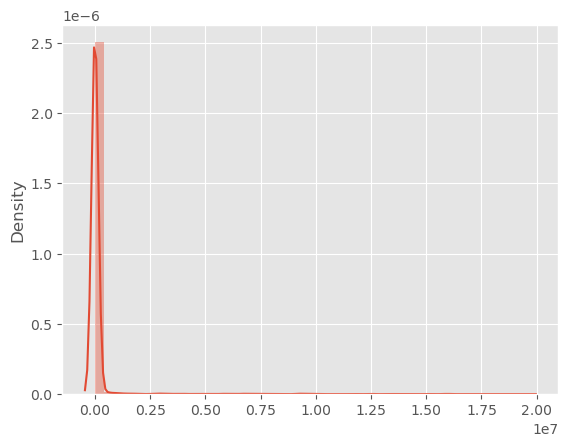

In [48]:
# Sample the dataframe
sample_df = df.select(['tripduration']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert the sample to a Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.distplot(pandas_df)


#### By the distribution plot, we can see that the NYC Citibike usage duration during storms are heavily skewed to the right, meaning that although most Citibike usages during the storm were within short durations, there were many extreme cases with much longer usage durations. 

#### It is also possible that people might leave the Citibike somewhere other than a Citibike station, making the usage time extremely long.

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

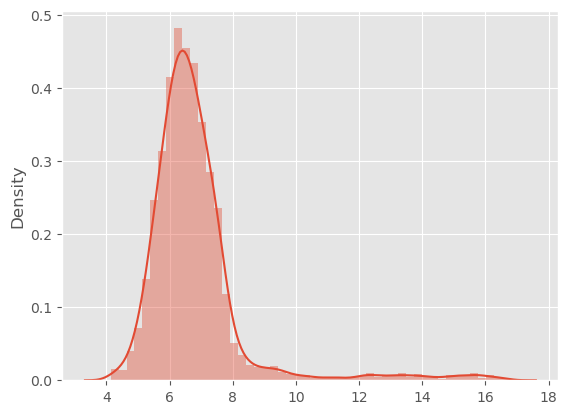

In [49]:
df = df.withColumn("log_tripduration", F.log(df.tripduration))

# Sample the dataframe
sample_df = df.select(['log_tripduration']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert the sample to a Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.distplot(pandas_df)

#### To reduce the skewness of the Citibike usage duration data while maintaining its characteristics, or reduce the extreme cases and make the data distribution to conform to a Normal distribution, so as to make our statistical analysis more valid, we apply a natural log transformation to the Citibike usage time in this case. 

#### We can see from the distribution plot of the log-transformed Citibike usage time data that it becomes more "Normal" now.

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

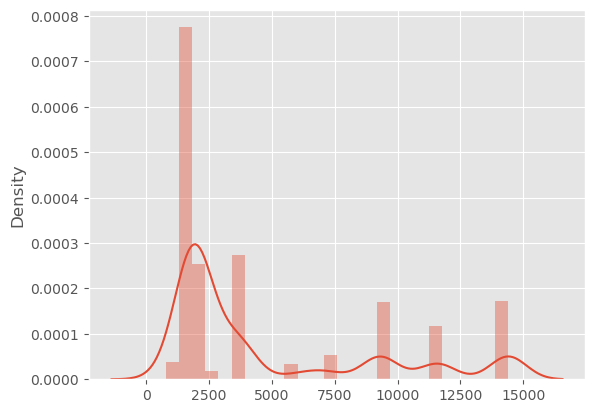

In [50]:
# Sample the dataframe
sample_df = df.select(['event_duration_in_sec']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert the sample to a Pandas DataFrame
pandas_df = sample_df.toPandas()

# Plot it
sns.distplot(pandas_df)


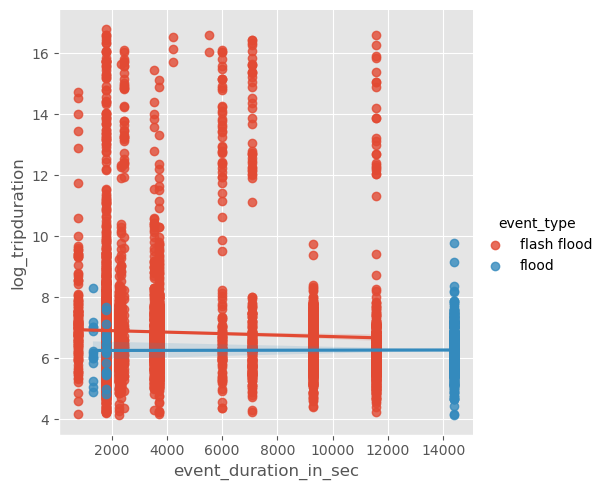

In [51]:
# Select the relevant columns and sample
sample_df = df.select(['event_duration_in_sec', 'log_tripduration', 'event_type']).sample(withReplacement=False, fraction=.4, seed=42)

# Convert to pandas dataframe
pandas_df = sample_df.toPandas()

# Linear model plot of pandas_df
sns.lmplot(x='event_duration_in_sec', y='log_tripduration', hue='event_type', data=pandas_df)
plt.show()

#### As seen from the scatterplot, the log-transformed Citibike usage time is negatively correlated with the duration of both flash flood and flood, with the flash flood having a higher correlation coefficient. 

#### This means that as the severe storm events like flash flood and flood last longer in NYC, people are less likely to use Citibikes during the storms; we can also see that the duration of flash flood has greater negative impacts on the NYC Citibike usages than duration of flood. 

#### Finally we can conclude that there exists a weakly negative linear relationship between the Citibike usage time and the duration of severe storms.

### Part b: Do storms impact Citibike trips from all stations equally in NYC during 2013-2017?

#### 1) Leave out the stations with trips less than 10 to reduce bias

#### 2) Separate the stations into quartiles according to the number of trips

#### 3) Compute the mean of potential decrease in trip durations for quartiles of stations during storms

In [52]:
df.select(['start_station_id']).distinct().count()

678

#### Create columns of avg and count to represent the average trip dutation and number of trip duration for the station that the trip belongs to

#### Count the number of trips whose starting stations have number of trips larger than 10 during the storm

In [53]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count,col,avg,sum,min,max,ceil

windowSpecAgg  = Window.partitionBy("start_station_id")
df = df.withColumn("count", count(col("tripduration")).over(windowSpecAgg)) \
  .where(col("count") > 10)

df.cache()
df.count()

17000

In [54]:
df.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_begin_time: timestamp (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: timestamp (nullable = true)
 |-- event_latitude: double (nullable = true)
 |-- event_longitude: double (nullable = true)
 |-- event_duration_in_sec: long (nullable = true)
 |-- log_tripduration: double (nullable = true)
 |-- count: long (nullable = false)



#### Count the number of stations with trips more than 10 during storm events

In [55]:
df.select("start_station_id").where(col("count") > 10).distinct().count()

338

#### The maximum number of trip for a station

In [56]:
max_count = df.select(col("count")).orderBy(col("count").desc()).collect()[0][0]
max_count

188

#### Find the cutoffs for the quartiles regarding number of trips

In [57]:
from pyspark.sql import DataFrameStatFunctions as statFunc

quantiles = statFunc(df).approxQuantile("count", [0.25, 0.5, 0.75], 0.0)
q1, q2, q3 = quantiles

quantiles

[44.0, 63.0, 85.0]

In [58]:
from pyspark.sql.functions import col, when

df = df.withColumn("quartile",
                            when(col("count") <= q1, "Q1")
                            .when((col("count") > q1) & (col("count") <= q2), "Q2")
                            .when((col("count") > q2) & (col("count") <= q3), "Q3")
                            .otherwise("Q4"))
df.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- episode_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_begin_time: timestamp (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: timestamp (nullable = true)
 |-- event_latitude: double (nullable = true)
 |-- event_longitude: double (nullable = true)
 |-- event_duration_in_sec: long (nullable = true)
 |-- log_tripduration: double (nullable = true)
 |-- count: long (nullable = false)
 |-- quartile: string (nullable = false)



#### Median trip duration in each quartile

In [59]:
from pyspark.sql.functions import sum, avg, max, count, col, percentile_approx

quartile_group_df = df.groupBy("quartile") \
    .agg(percentile_approx("tripduration", 0.5).alias("median_dur")) \
    .orderBy(col("quartile").asc())

quartile_group_df.show()

+--------+----------+
|quartile|median_dur|
+--------+----------+
|      Q1|       763|
|      Q2|       670|
|      Q3|       622|
|      Q4|       676|
+--------+----------+



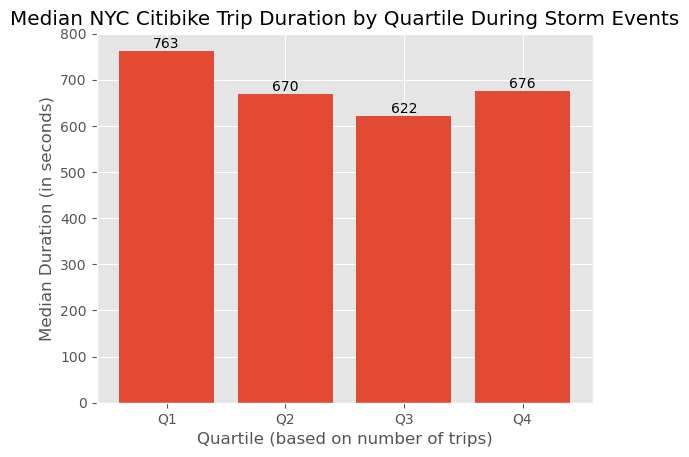

In [60]:
import matplotlib.pyplot as plt

pandas_df = quartile_group_df.select("quartile", "median_dur").toPandas()

fig, ax = plt.subplots()

# Set the x-axis and y-axis data
bars = ax.bar(pandas_df['quartile'], pandas_df['median_dur'])

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Quartile (based on number of trips)')
ax.set_ylabel('Median Duration (in seconds)')

# Set the title for the plot
ax.set_title('Median NYC Citibike Trip Duration by Quartile During Storm Events')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


# Show the plot
plt.show()

#### Median trip duration in each quartile from the trips dataframe whether there is a storm or not

In [61]:
q1_id_rows = df.select("start_station_id").where(col('quartile') == 'Q1').distinct().collect()
q1_id_list = [row.start_station_id for row in q1_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q1_id_list))
trips_q1_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q1_median_dur

665

In [62]:
q2_id_rows = df.select("start_station_id").where(col('quartile') == 'Q2').distinct().collect()
q2_id_list = [row.start_station_id for row in q2_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q2_id_list))
trips_q2_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q2_median_dur

615

In [63]:
q3_id_rows = df.select("start_station_id").where(col('quartile') == 'Q3').distinct().collect()
q3_id_list = [row.start_station_id for row in q3_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q3_id_list))
trips_q3_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q3_median_dur

592

In [64]:
q4_id_rows = df.select("start_station_id").where(col('quartile') == 'Q4').distinct().collect()
q4_id_list = [row.start_station_id for row in q4_id_rows]

filtered_trips = trips.where(col("start_station_id").isin(q4_id_list))
trips_q4_median_dur = filtered_trips.select(percentile_approx("tripduration", 0.5)).collect()[0][0]

trips_q4_median_dur

633

In [65]:
data = [("Q1", trips_q1_median_dur),
        ("Q2", trips_q2_median_dur),
        ("Q3", trips_q3_median_dur),
        ("Q4", trips_q4_median_dur)]
columns = ["quartile", "median_dur"]

trips_median_dur_df = spark.createDataFrame(data, columns)
trips_median_dur_df.show()

+--------+----------+
|quartile|median_dur|
+--------+----------+
|      Q1|       665|
|      Q2|       615|
|      Q3|       592|
|      Q4|       633|
+--------+----------+



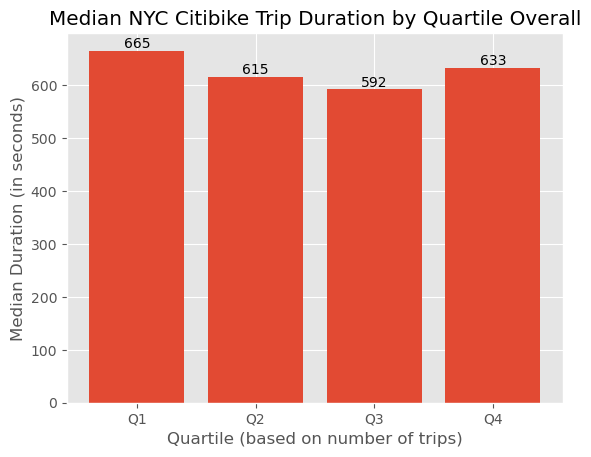

In [66]:
import matplotlib.pyplot as plt

pandas_df = trips_median_dur_df.select("quartile", "median_dur").toPandas()

fig, ax = plt.subplots()

# Set the x-axis and y-axis data
bars = ax.bar(pandas_df['quartile'], pandas_df['median_dur'])

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Quartile (based on number of trips)')
ax.set_ylabel('Median Duration (in seconds)')

# Set the title for the plot
ax.set_title('Median NYC Citibike Trip Duration by Quartile Overall')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


# Show the plot
plt.show()

### Conclusions of Part b: Do storms impact Citibike trips from all stations equally in NYC during 2013-2017?

#### 1) The storms did impact Citibike trips from all stations roughly equally in NYC during 2013-2017. 

#### The number of Citibike stations that are potentially under the storm impacts in NYC is 678; after I left out stations with less than 10 trips, the number of stations was reduced to 338, still too large to be fit onto one graph. Therefore, In the data analysis, I defined the quartiles of bike stations by the number of trips starting from that station and get four divisions of bike stations. Besides, to view the average pattern in the quartiles of stations, I chose the median over mean, because the median of trip durations is less susceptible to outliers compared to the mean. 

#### As we can see from the two bar plots together, whether during storms or overall, the four median Citibike trip durations remained in the same order: Q1 being the longest, Q4 being the second, Q2 being the third, and Q4 being the shortest. Besides, the four median bike trip durations all slightly increase during storm events compared to the results overall, which are kind of counter-intuitive at first but are left open to explanations. 

##### a) Self-selection of riders: During a severe storm, only a small subset of riders may choose to use Citibike. These riders may have higher tolerance for adverse weather conditions, have a stronger need to reach their destination, or be more experienced cyclists. As a result, they might take longer trips compared to the average user in normal weather conditions.

##### b) Reduced alternatives: In severe storm conditions, public transportation such as subways and buses might experience delays, reduced frequency, or even temporary shutdowns. Taxis and rideshares might also be less available or have higher prices due to increased demand. This could lead some people to choose Citibike as a mode of transportation and take longer trips than they would otherwise.

##### c) Navigational challenges: During a severe storm, visibility may be reduced, streets might be flooded, and there may be fallen trees or debris blocking the usual routes. Riders might need to take detours or travel at a slower pace, leading to longer trip durations.

##### d) Availability of bikes and docking stations: Due to fewer people using Citibike during severe storms, bikes and docking stations might be more available, making it more convenient for users to take longer trips without worrying about finding a docking station at their destination.

#### 2) The two longest median Citibike trip durations came from stations with the lowest and highest number of trips. And this discovery can be explained in several different ways.

##### a) Station location and demographics: Stations with the lowest number of bike trips might be located in less densely populated areas or areas with fewer points of interest, such as parks or recreational facilities. Users starting their trips from these stations may be more likely to engage in leisurely activities or longer exercise routines, leading to longer trip durations. On the other hand, stations with the highest number of bike trips might be located in busy urban areas, close to popular destinations, where people are more likely to use Citibike for commuting or running errands. These users might take slightly longer trips to reach their destinations due to factors like traffic, congestion, or longer distances between points of interest.

##### b) Availability of bikes and docking stations: Stations with a lower number of bike trips might have higher availability of bikes and docking stations. This could encourage users to take longer trips without worrying about finding a docking station at their destination. Conversely, stations with a higher number of bike trips might have limited availability of bikes and docking stations. Users starting their trips from these stations might be more inclined to take longer trips to avoid the hassle of finding a docking station in a congested area.

***
# Section 2

### Conducting a relative study between NYC Bikes dataset and New York City 311 Calls Dataset to see whether certain parameters such as safety calls or increased traffic affects the bike rental industry in the areas.
***

# Next we shall be analysing two datasets which are namely 
1. NYC Citi Bike Trips dataset (https://console.cloud.google.com/marketplace/details/city-of-new-york/nyc-citi-bike?project=is-843-project-t4)
2. NYC 311 Calls dataset (https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=new_york_311&page=dataset&project=is-843-project-t4)

## The question that we will try to be answering is that
1. Are areas with more number of traffic or safety calls less likely to have users rent bikes from
2. Is there any form of visual relation between the number of bikes rented vs the number of such calls made by the day

### Expected Answers
1. Yes if people in an area are concerned for their safety due to any external factor then they would be less likely to rent bikes from those stations
2. We should see a negative relation in this scenario

In [62]:
nyc_bikes = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_citibike.citibike_trips').option('header', "true").load()
calls_311 = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_311.311_service_requests').option("header","true").load()
nyc_bikes = nyc_bikes.withColumn("starttime", F.col("starttime").cast("timestamp"))
nyc_bikes = nyc_bikes.withColumn("stoptime", F.col("stoptime").cast("timestamp"))

In [63]:
nyc_bikes = nyc_bikes.na.drop(subset=["tripduration"])
calls_311 = calls_311.na.drop(subset=["created_date"])
calls_311_needed = calls_311.where((calls_311.complaint_type=="Traffic Signal Condition") | (calls_311.complaint_type=="SAFETY"))
calls_311_needed = calls_311.select(calls_311['created_date'].cast(TimestampType()), "latitude", "longitude")

In [64]:
nyc_bikes = nyc_bikes.na.drop(subset=["start_station_latitude","start_station_longitude","end_station_latitude","end_station_longitude"])
calls_311 = calls_311.na.drop(subset=["latitude","longitude"])
nyc_bikes = nyc_bikes.drop("start_station_name","end_station_name","bikeid","usertype","customer_plan")
calls_311 = calls_311.drop("unique_key",'cross_street_1','cross_street_2','intersection_street_1','intersection_street_2','address_type','city','landmark','facility_type','due_date',
 'resolution_description',
 'resolution_action_updated_date',
 'community_board',
 'borough',
 'x_coordinate',
 'y_coordinate',
 'park_facility_name',
 'park_borough',
 'bbl',
 'open_data_channel_type',
 'vehicle_type',
 'taxi_company_borough',
 'taxi_pickup_location',
 'bridge_highway_name',
 'bridge_highway_direction',
 'road_ramp',
 'bridge_highway_segment')

nyc_bikes = nyc_bikes.repartition(20)
calls_311 = calls_311.repartition(20)
calls_311_needed = calls_311_needed.repartition(20)

In [65]:
nyc_bikes.printSchema()
calls_311.printSchema()
nyc_bikes.cache()
calls_311.cache()
calls_311_needed.cache()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: long (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- gender: string (nullable = true)

root
 |-- created_date: timestamp (nullable = true)
 |-- closed_date: timestamp (nullable = true)
 |-- agency: string (nullable = true)
 |-- agency_name: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- descriptor: string (nullable = true)
 |-- location_type: string (nullable = true)
 |-- incident_zip: string (nullable = true)
 |-- incident_address: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- status: string (nullable = true

DataFrame[created_date: timestamp, latitude: double, longitude: double]

In [66]:
print(" The NYC Bikes dataframe has {} records".format(nyc_bikes.count()))

 The NYC Bikes dataframe has 53108721 records


In [67]:
print(" The 311 Calls dataframe has {} records".format(calls_311.count()))

 The 311 Calls dataframe has 24878923 records


In [68]:
calls_311_safety = calls_311_needed.where((calls_311.complaint_type=="SAFETY"))
calls_311_traffic = calls_311_needed.where((calls_311.complaint_type=="Traffic Signal Condition"))

In [69]:
py_calls_safety = calls_311_safety.toPandas()
py_calls_traffic = calls_311_traffic.toPandas()

In [70]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://ontheworldmap.com/usa/city/new-york-city/map-of-new-york-city-max.jpg')
img = Image.open(BytesIO(response.content))

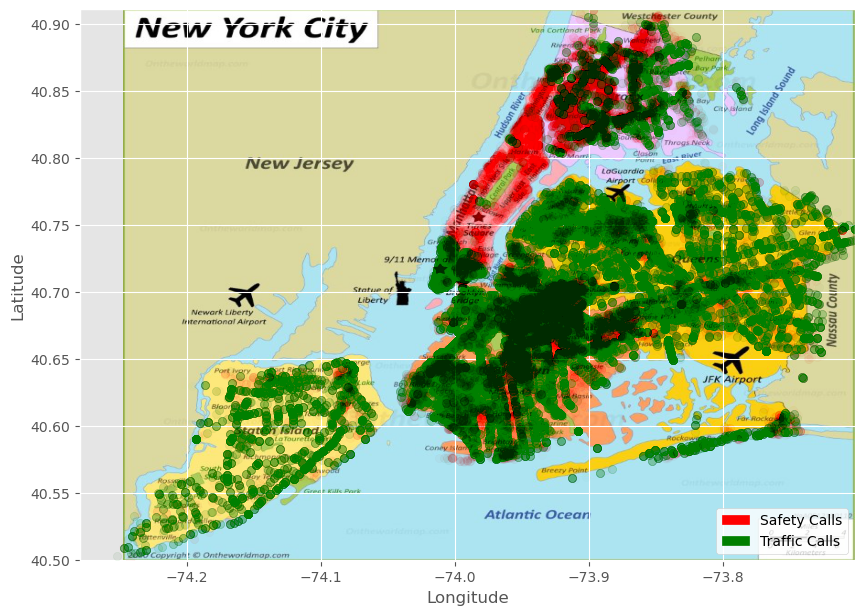

In [73]:
plt.figure(figsize=(10,8))
plt.imshow(img,zorder=0,extent=[py_calls_safety['longitude'].min(),py_calls_safety['longitude'].max(),py_calls_safety['latitude'].min(),py_calls_safety['latitude'].max()])
ax = plt.gca()
# py_calls_sample.plot(x='longitude', y='latitude', kind='scatter', alpha=0.4, 
#          s= housing['population']/100, label='population', ax=ax,
#          c= 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, 
#          zorder=5)
safety_points = plt.scatter(py_calls_safety['longitude'], py_calls_safety['latitude'], alpha=0.01, color='red', label='Safety Calls')
traffic_points = plt.scatter(py_calls_traffic['longitude'], py_calls_traffic['latitude'], alpha=0.01, color='green', label='Traffic Calls')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
red_patch = mpatches.Patch(color='red', label='Safety Calls')
green_patch = mpatches.Patch(color='green', label='Traffic Calls')
plt.legend(handles=[red_patch, green_patch], loc='lower right', facecolor='white')
    
plt.show()

### In the above analysis we can see that more number of calls for both traffic and safety concerns are concentrated near the City area, in the next graph we see that in this area bikes taken on rent are comparitively lesser

In [74]:
nyc_bikes_sample = nyc_bikes.sample(withReplacement = False, fraction = 0.01, seed = 1220)
nyc_bikes_filtered_pandas = nyc_bikes_sample.toPandas()

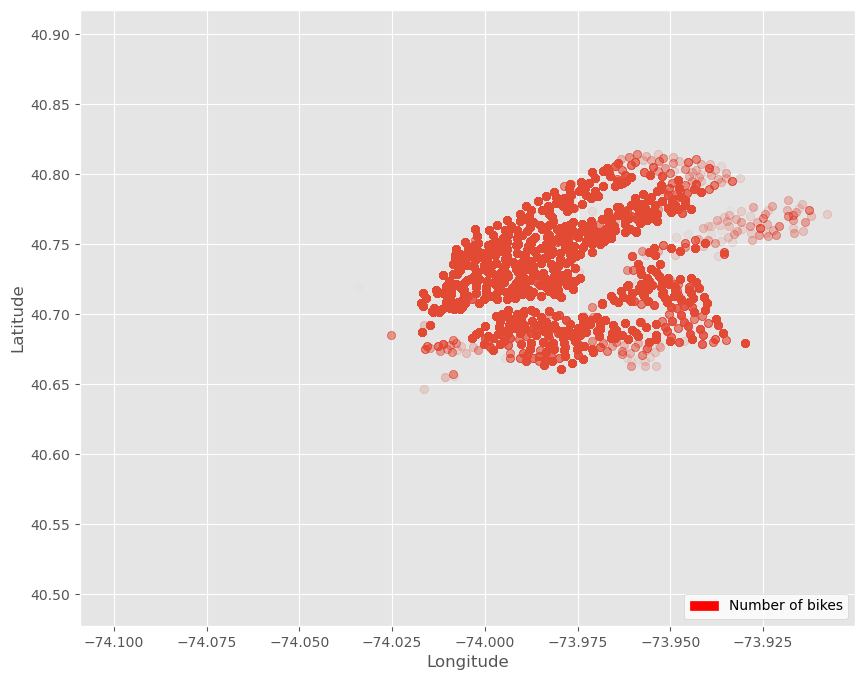

In [75]:
plt.figure(figsize=(10,8))
plt.xlim(-74.10909,-73.90018)
plt.ylim(40.477399, 40.917577)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(nyc_bikes_filtered_pandas['start_station_longitude'], nyc_bikes_filtered_pandas['start_station_latitude'],label='Number of Bikes', alpha=0.01)
red_patch = mpatches.Patch(color='red', label='Number of bikes')
plt.legend(handles=[red_patch], loc='lower right', facecolor='white')

### We can see that bikes are taken lesser in areas which were marked green in the above map, green was the color used to signify traffic issues. Thus our hypothesis was correct and we proved what we were looking for

##### Note for grader: Please note that there was a major issue applying the above graph on an image as the image was getting skewed due to which the analysis had to be done this way, further due to unability of converting geo locations to Pin codes the data is slightly less accurate, for future scopes of works we can use pin codes instead of geo locations.

# Analysis of the bikes vs calls data

#### We made an analysis that bike rides are less common in areas of more traffic on a map plot, but is this trend observed yearly as well? Next we shall be doing this analysis to plot the trend of bikes rented by year and month over the traffic conditions for that year and month

**Columns in this Dataset**

|Column Name|Description|Type|
|--|--|--|
|unique_key|Unique identifier for the record|Long|
|created_date|Timestamp of the call being made, which is unique to the incident.|Timestamp|
|closed_date|Timestamp of the call being closed, which is unique to the incident.|Timestamp|
|agency|Agency handling the call|String|
|agency_name|Name of the agency|String|
|complaint_type|Type of the complaint, Traffic and Safety is pertinent to our analysis|String|
|incident_zip|Zipcode of the incident|String|
|longitude|Longitude of the location where the incident took place|String|
|latitide|latitude of the location where the incident took place|String|


In [76]:
nyc_bikes.selectExpr("min(starttime)", "max(starttime)").show(truncate=False)

+-------------------+-----------------------+
|min(starttime)     |max(starttime)         |
+-------------------+-----------------------+
|2013-07-01 00:00:00|2018-05-31 23:59:59.606|
+-------------------+-----------------------+



In [77]:
calls_311.selectExpr("min(created_date)", "max(created_date)").show(truncate=False)

+-------------------+-------------------+
|min(created_date)  |max(created_date)  |
+-------------------+-------------------+
|2010-01-01 00:00:00|2021-11-08 02:00:12|
+-------------------+-------------------+



#### Filtering 311 Calls dataframe to only keep the calls between 2013 and 2018 as that is our dataset values for nyc bikes dataset

In [78]:
filtered_df_311 = calls_311_traffic.filter((calls_311_traffic.created_date >= "2013-07-01") & (calls_311_traffic.created_date <= "2018-05-31"))

# Group the data by month and sum the values
grouped_df_311 = filtered_df_311.groupBy(F.year("created_date").alias("year"), F.month("created_date").alias("month")).agg(F.count("*"))
grouped_df_bikes = nyc_bikes.groupBy(F.year("starttime").alias("year"), F.month("starttime").alias("month")).agg(F.count("*"))

In [79]:
pandas_df_311 = grouped_df_311.toPandas()
grouped_df_pandas = grouped_df_bikes.toPandas()
pandas_df_311["year_month"] = pandas_df_311.apply(lambda row: "{}-{:02d}".format(row["year"], row["month"]), axis=1)
grouped_df_pandas["year_month"] = grouped_df_pandas.apply(lambda row: "{}-{:02d}".format(row["year"], row["month"]), axis=1)
pandas_df_311.head()
grouped_df_pandas.head()

,year,month,count(1),year_month
0,2015,2,196930,2015-02
1,2017,8,1816498,2017-08
2,2014,4,670780,2014-04
3,2017,10,1897592,2017-10
4,2016,7,1380110,2016-07


In [80]:
grouped_df_pandas = grouped_df_pandas.rename(columns={'count(1)': 'bikes_count_by_month'})
pandas_df_311 = pandas_df_311.rename(columns={'count(1)': '311_calls_by_month'})

/tmp/ipykernel_5481/759301706.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(bar_data['year_month'], rotation=45)


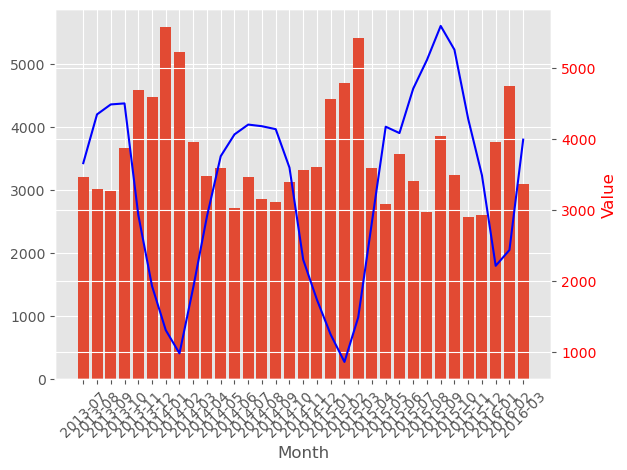

In [81]:
bar_data = pandas_df_311[(pandas_df_311['year'] == 2014) | (pandas_df_311['year'] == 2015) | (pandas_df_311['year_month'] <= '2016-03')]
line_data = grouped_df_pandas[(grouped_df_pandas['year'] == 2014) | (grouped_df_pandas['year'] == 2015) | (grouped_df_pandas['year_month'] <= '2016-03')]

bar_data = bar_data.sort_values('year_month')
line_data = line_data.sort_values('year_month')

scale_factor = bar_data['311_calls_by_month'].max() / line_data['bikes_count_by_month'].max()

# scale the values of the line chart
line_data['bikes_count_by_month'] = line_data['bikes_count_by_month'] * scale_factor

# create the bar chart
fig, ax = plt.subplots()
ax.bar(bar_data['year_month'], bar_data['311_calls_by_month'])

# set the x-axis label for the bar chart
ax.set_xlabel('Month')
ax.set_xticklabels(bar_data['year_month'], rotation=45)

# create the line chart on the same axis
ax2 = ax.twinx()
ax2.plot(line_data['year_month'], line_data['bikes_count_by_month'], color='blue')

# set the y-axis label for the line chart
ax2.set_ylabel('Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# show the plot
plt.show()

### It is convenient to note that in the above analysis we have used 3 years data 2014, 2015 and 2016 to perform our plot to keep it readable. Further only data till March 2016 is considered because post that date certain months and data is missing

## From the visuals we can see that with an increase in calls of traffic violations or safety concerns the number of bikes rented go down. This is plausible and should happen as when people see that traffic conditions or safety scenarios are not favorable they choose to not use bikes on the street 

***
# Section 3
### Analysing the Citi Bikes dataset to further see how we can co-relate it with weather dataset and perform analysis on it using ML tools to gather more data
***

In [71]:
start_station_id_counts = nyc_bikes.groupBy("start_station_id").count().orderBy(F.col("count").desc())
end_station_id_counts = nyc_bikes.groupBy("end_station_id").count().orderBy(F.col("count").desc())
top_start_ids = start_station_id_counts.select("start_station_id", "count").limit(50).collect()
top_end_ids = end_station_id_counts.select("end_station_id", "count").limit(50).collect()


In [72]:
start_ids = [row.start_station_id for row in top_start_ids]
start_counts = [row["count"] for row in top_start_ids]
end_ids = [row.end_station_id for row in top_end_ids]
end_counts = [row["count"] for row in top_end_ids]


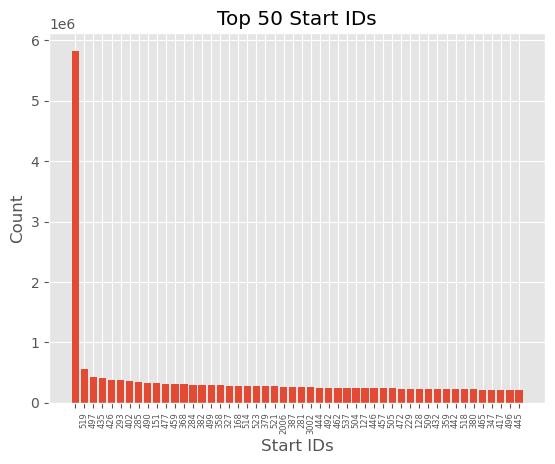

In [73]:
plt.bar(range(len(start_ids)), start_counts)
plt.xticks(range(len(start_ids)), start_ids,rotation='vertical',fontsize=6)
plt.xlabel("Start IDs")
plt.ylabel("Count")
plt.title("Top 50 Start IDs")
plt.show()

Text(0.5, 1.0, 'Top 50 End IDs')

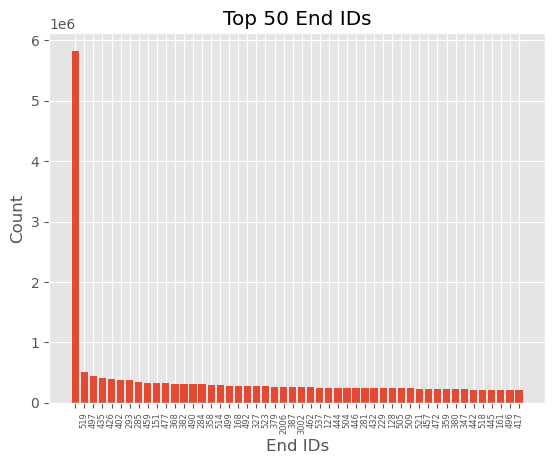

In [74]:
plt.figure()
plt.bar(range(len(end_ids)), end_counts)
plt.xticks(range(len(end_ids)), end_ids,rotation='vertical',fontsize=6)
plt.xlabel("End IDs")
plt.ylabel("Count")
plt.title("Top 50 End IDs")

In [75]:
total_count = start_station_id_counts.select(F.sum("count")).collect()[0][0]
sorted_df = start_station_id_counts.orderBy(F.desc("count"))
cumulative_sum_window = Window.orderBy(F.desc("count")).rowsBetween(Window.unboundedPreceding, Window.currentRow)
cumulative_sum_df = sorted_df.withColumn("cumulative_sum", F.sum("count").over(cumulative_sum_window))

# Filter the dataframe to include only the rows where the cumulative sum of counts is less than or equal to 25% of the total count
filtered_df_25 = cumulative_sum_df.filter("cumulative_sum <= {}".format(total_count * 0.25))
# Count the number of distinct ids in the filtered dataframe
num_ids_25 = filtered_df_25.select("start_station_id").distinct().count()

# Print the result
print("Number of ids in the first 25% of counts: {}".format(num_ids_25))

23/04/30 13:15:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:20 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:21 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Number of ids in the first 25% of counts: 29


In [76]:
filtered_df_50 = cumulative_sum_df.filter("cumulative_sum <= {}".format(total_count * 0.5))
# Count the number of distinct ids in the filtered dataframe
num_ids_50 = filtered_df_50.select("start_station_id").distinct().count()

# Print the result
print("Number of ids in the second 25% of counts: {}".format(num_ids_50-num_ids_25))

23/04/30 13:15:30 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:35 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:36 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Number of ids in the second 25% of counts: 74


In [77]:
filtered_df_75 = cumulative_sum_df.filter("cumulative_sum <= {}".format(total_count * 0.75))
# Count the number of distinct ids in the filtered dataframe
num_ids_75 = filtered_df_75.select("start_station_id").distinct().count()

# Print the result
print("Number of ids in the third 25% of counts: {}".format(num_ids_75-num_ids_50))

23/04/30 13:15:41 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:47 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Number of ids in the third 25% of counts: 118


In [78]:
filtered_df_100 = cumulative_sum_df.filter("cumulative_sum <= {}".format(total_count * 1))
# Count the number of distinct ids in the filtered dataframe
num_ids_100 = filtered_df_100.select("start_station_id").distinct().count()

# Print the result
print("Number of ids in the fourth 25% of counts: {}".format(num_ids_100-num_ids_75))

23/04/30 13:15:52 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/30 13:15:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

Number of ids in the fourth 25% of counts: 661


We can observe that first 25% of the orders happened in 47 stations. Second 25% of the orders happened in 73 stations. Third 25% of the orders happened in 116 stations. Last 25% of the orders happened in 645 stations. We can concluded that 75% of the orders happened in 26.8% stations. Therefore, we can assume 75% of the bikes exists in 26.8% stations. If we want to evaluate the impact of severe weather against the bike, it will be more accurate by checking those 26.8% stations instead of checking all the stations.

## The above counts how many times the station_id appears in the dataframe and find out the hottest station_id

***
# Section 4
### Having analysed the citi bikes dataset, next we are going to be performing a study between the citi bikes dataset and weather datasets to see how patterns affect the usage of bikes and their rentals
***

In [4]:
nyc_bikes_weather = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_citibike.citibike_trips').option('header', "true").load()
nyc_bikes_weather.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: string (nullable = true)
 |-- stoptime: string (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: long (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bikeid: long (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- customer_plan: string (nullable = true)



In [5]:
nyc_bikes_weather = nyc_bikes_weather.withColumn("starttime", F.col("starttime").cast("timestamp"))
nyc_bikes_weather = nyc_bikes_weather.withColumn("stoptime", F.col("stoptime").cast("timestamp"))
nyc_bikes_weather.printSchema()

root
 |-- tripduration: long (nullable = true)
 |-- starttime: timestamp (nullable = true)
 |-- stoptime: timestamp (nullable = true)
 |-- start_station_id: long (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: long (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bikeid: long (nullable = true)
 |-- usertype: string (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- customer_plan: string (nullable = true)



In [6]:
nyc_bikes_weather = nyc_bikes_weather.na.drop(subset=["tripduration"])
nyc_bikes_weather = nyc_bikes_weather.na.drop(subset=["start_station_latitude","start_station_longitude","end_station_latitude","end_station_longitude"])

In [7]:
nyc_bikes_weather = nyc_bikes_weather.drop('tripduration', 'stoptime', 'start_station_id', 'start_station_name', 'end_station_id','end_station_name', 'end_station_latitude', 'end_station_longitude', 'bikeid','usertype','birth_year','gender','customer_plan','start_station_latitude','start_station_longitude')

In [6]:
nyc_bikes_weather.printSchema()

root
 |-- starttime: timestamp (nullable = true)



In [8]:
nyc_bikes_weather = nyc_bikes_weather.withColumn("starttime", F.col("starttime").cast("timestamp"))

In [87]:
nyc_bikes_weather.limit(3).toPandas()

,starttime
0,2017-10-01 09:16:46
1,2014-07-31 23:46:38
2,2014-12-11 11:35:12


In [9]:
nyc_bikes_weather.cache()

DataFrame[starttime: timestamp]

In [10]:
nyc_bikes_weather = nyc_bikes_weather.repartition(20)

In [10]:
print(" The NYC Bikes dataframe has {} records".format(nyc_bikes_weather.count()))

 The NYC Bikes dataframe has 53108721 records


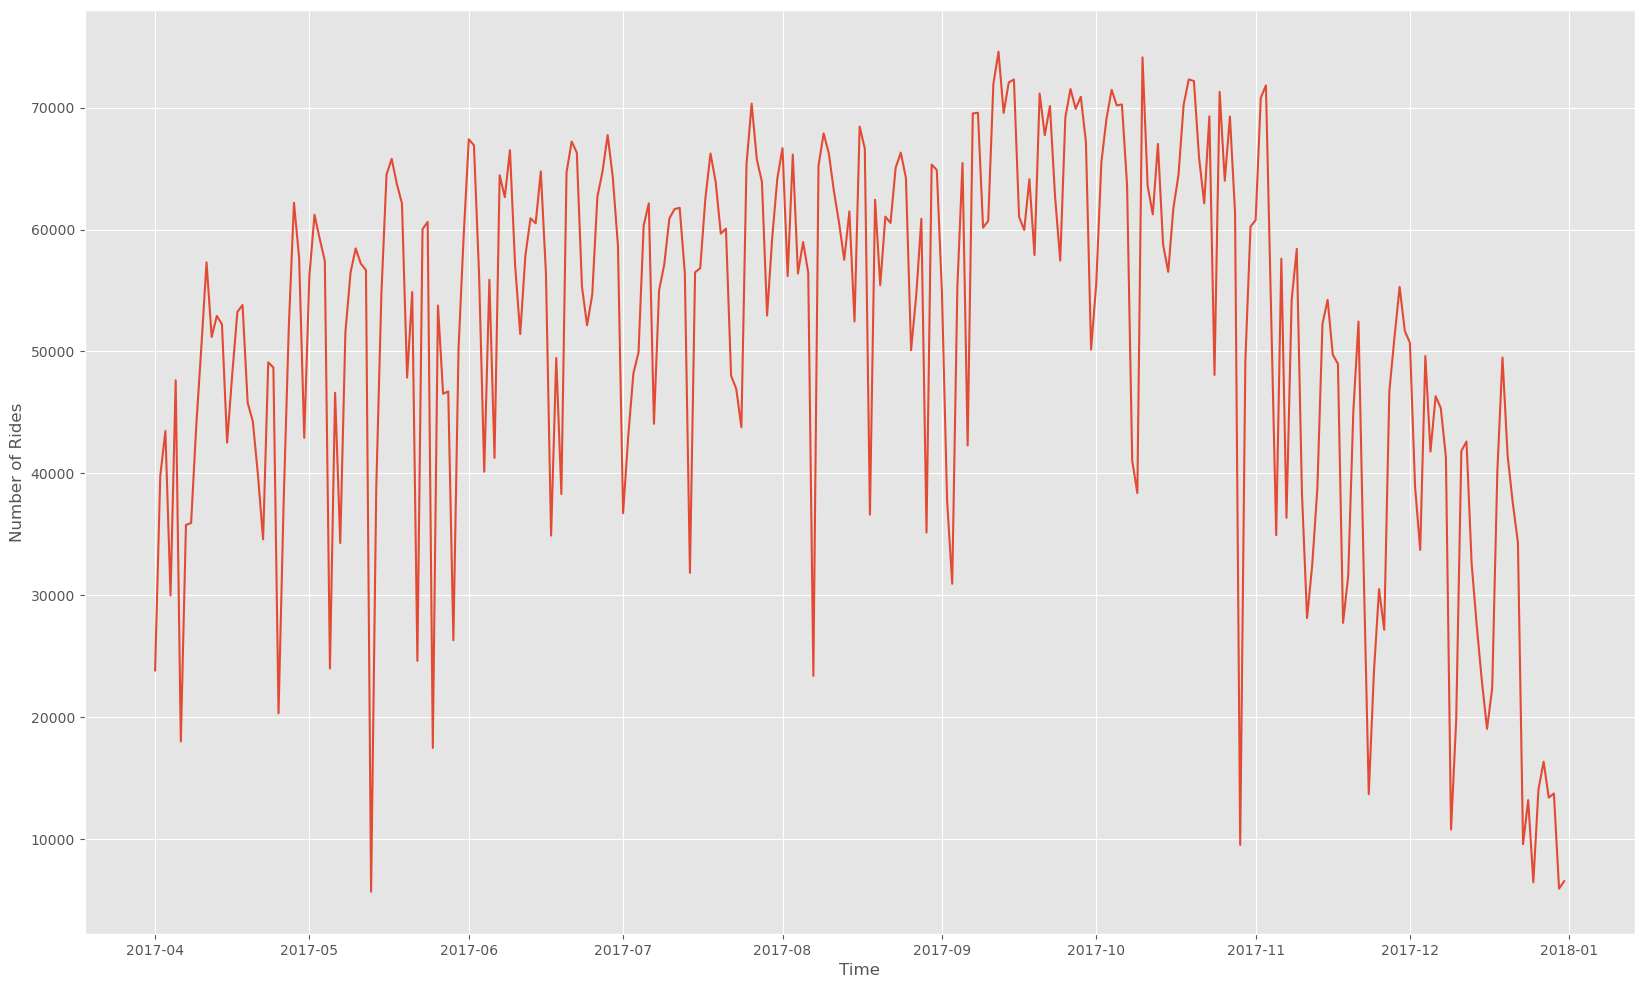

In [11]:
nyc_bikes_weather = nyc_bikes_weather.filter((F.year("starttime") == 2017))

rides_over_time = nyc_bikes_weather.groupBy(F.date_trunc("day", "starttime").alias("day")).count()

rides_over_time = rides_over_time.orderBy(F.asc("day"))

rides_over_time_pd = rides_over_time.select("*").toPandas()

fig = plt.figure(figsize=(20, 12))

# Plot the number of rides over time
plt.plot(rides_over_time_pd["day"],rides_over_time_pd["count"])
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.show()

In [159]:
pandas_df.head()

,event_duration_in_sec,log_tripduration,event_type
0,3720,7.694393,flash flood
1,14400,5.986452,flood
2,7080,13.041195,flash flood
3,1800,6.932448,flash flood
4,1800,6.933423,flash flood


In [12]:
weather_schema = StructType([StructField("episode_id", IntegerType(), True),
                            StructField("event_id", IntegerType(), True),
                            StructField("state", StringType(), True ),
                            StructField("state_fips_code", DoubleType(), True),
                            StructField("event_type", StringType(), True),
                            StructField("cz_type", StringType(), True  ),
                            StructField("cz_fips_code", DoubleType(), True ),
                            StructField("cz_name", StringType(), True ),
                            StructField("wfo", StringType(), True),
                            StructField("event_begin_time", TimestampType(), True),
                            StructField("event_timezone", StringType(), True),
                            StructField("event_end_time", TimestampType(), True),
                            StructField("injuries_direct", IntegerType(), True),
                            StructField("injuries_indirect", IntegerType(), True),
                            StructField("deaths_direct", IntegerType(), True ),
                            StructField("deaths_indirect", IntegerType(), True),
                            StructField("damage_property", IntegerType(), True ),
                            StructField("damage_crops", IntegerType(), True),
                            StructField("source", StringType(), True ),
                            StructField("magnitude", IntegerType(), True),
                            StructField("magnitude_type", StringType(), True),
                            StructField("flood_cause", StringType(), True ),
                            StructField("tor_f_scale", DoubleType(), True ),
                            StructField("tor_length", IntegerType(), True ),
                            StructField("tor_width", IntegerType(), True ),
                            StructField("tor_other_wfo", IntegerType(), True ),
                            StructField("location_index", IntegerType(), True ),
                            StructField("event_range", IntegerType(), True ),
                            StructField("event_azimuth", IntegerType(), True ),
                            StructField("reference_location", IntegerType(), True ),
                            StructField("event_latitude", DoubleType(), True ),
                            StructField("event_longitude", DoubleType(), True ),
                            StructField("event_point", IntegerType(), True )
                            ])

In [13]:
weather = spark.read.format("csv")\
  .option("header", "true")\
  .schema(weather_schema)\
  .load(data + "storms_2017.csv")

In [14]:
weather.printSchema()


root
 |-- episode_id: integer (nullable = true)
 |-- event_id: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- state_fips_code: double (nullable = true)
 |-- event_type: string (nullable = true)
 |-- cz_type: string (nullable = true)
 |-- cz_fips_code: double (nullable = true)
 |-- cz_name: string (nullable = true)
 |-- wfo: string (nullable = true)
 |-- event_begin_time: timestamp (nullable = true)
 |-- event_timezone: string (nullable = true)
 |-- event_end_time: timestamp (nullable = true)
 |-- injuries_direct: integer (nullable = true)
 |-- injuries_indirect: integer (nullable = true)
 |-- deaths_direct: integer (nullable = true)
 |-- deaths_indirect: integer (nullable = true)
 |-- damage_property: integer (nullable = true)
 |-- damage_crops: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- magnitude: integer (nullable = true)
 |-- magnitude_type: string (nullable = true)
 |-- flood_cause: string (nullable = true)
 |-- tor_f_scale: double (nu

In [14]:
required_cols = ['state', 'cz_name','event_type','state_fips_code', 'event_begin_time']
weather = weather.select(required_cols)

In [15]:
weather.cache()

DataFrame[state: string, cz_name: string, event_type: string, state_fips_code: double, event_begin_time: timestamp]

In [17]:
print(" The Storms 2017 dataframe has {} records".format(weather.count()))

 The Storms 2017 dataframe has 81822 records


In [21]:
print(" The NY 2017 dataframe has {} records".format(ny_weather_df.count()))

 The NY 2017 dataframe has 1937 records


In [16]:
ny_weather_df = weather.filter(weather.state_fips_code == 36)

In [17]:
ny_weather_df = ny_weather_df.dropDuplicates()
#clean the data

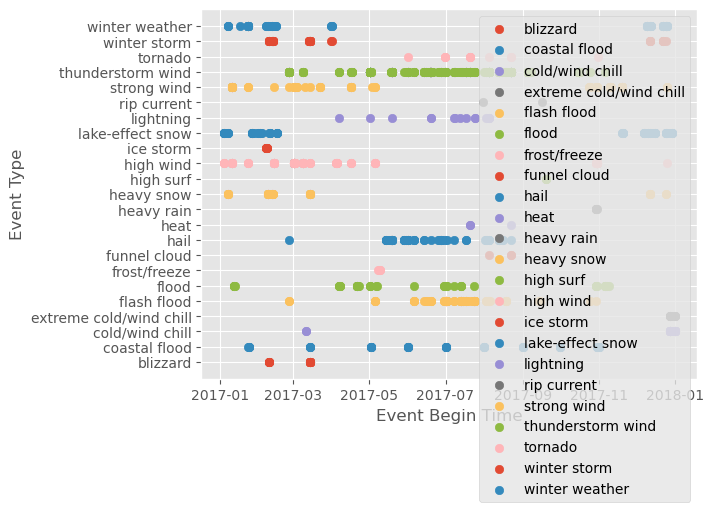

In [18]:
ny_weather_pd = ny_weather_df.select("*").toPandas()

fig, ax = plt.subplots()

for event_type, group in ny_weather_pd.groupby('event_type'):
    ax.scatter(group['event_begin_time'], [event_type] * len(group), label=event_type)

ax.legend()
ax.set_xlabel('Event Begin Time')
ax.set_ylabel('Event Type')

plt.show()

In [19]:
df_truncated = ny_weather_df.select(F.date_trunc('day', ny_weather_df.event_begin_time).alias('date'),'event_type')
#truncate datetime to day

In [20]:
df_combined = df_truncated.groupby('date').agg(F.concat_ws(", ", F.collect_list('event_type')).alias('event_types'))
#combine event_types so there is one line per date

In [21]:
df_combined_pd = df_combined.toPandas().reset_index()

In [173]:
print(df_combined_pd)

     index       date                                        event_types
0        0 2017-08-02  hail, flash flood, hail, thunderstorm wind, th...
1        1 2017-07-17  flash flood, flash flood, flash flood, hail, f...
2        2 2017-12-25  winter weather, winter weather, winter storm, ...
3        3 2017-03-14  blizzard, blizzard, heavy snow, heavy snow, he...
4        4 2017-02-25  flash flood, hail, thunderstorm wind, thunders...
..     ...        ...                                                ...
121    121 2017-06-20                                  thunderstorm wind
122    122 2017-01-13                                              flood
123    123 2017-02-10                                   lake-effect snow
124    124 2017-05-08                                       frost/freeze
125    125 2017-05-31  hail, tornado, hail, hail, hail, hail, hail, h...

[126 rows x 3 columns]


In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a UDF to remove duplicates from a string of comma-separated values
@udf(StringType())
def remove_duplicates(s):
    return ', '.join(sorted(set(x.strip() for x in s.split(','))))

# Apply the remove_duplicates() UDF to the 'event_types' column of df_combined
df_combined = df_combined.withColumn('event_types', remove_duplicates(df_combined['event_types']))

# Print the resulting DataFrame
df_combined.show()

+-------------------+--------------------+
|               date|         event_types|
+-------------------+--------------------+
|2017-08-02 00:00:00|flash flood, hail...|
|2017-07-17 00:00:00|flash flood, hail...|
|2017-12-25 00:00:00|high wind, lake-e...|
|2017-07-30 00:00:00|         rip current|
|2017-11-07 00:00:00|               flood|
|2017-03-14 00:00:00|blizzard, coastal...|
|2017-02-25 00:00:00|flash flood, hail...|
|2017-09-05 00:00:00|   thunderstorm wind|
|2017-07-23 00:00:00|flash flood, thun...|
|2017-12-29 00:00:00|    lake-effect snow|
|2017-02-09 00:00:00|blizzard, heavy s...|
|2017-10-30 00:00:00|coastal flood, fl...|
|2017-07-13 00:00:00|flash flood, floo...|
|2017-03-11 00:00:00|     cold/wind chill|
|2017-03-31 00:00:00|winter storm, win...|
|2017-05-14 00:00:00|                hail|
|2017-11-19 00:00:00|lake-effect snow,...|
|2017-01-12 00:00:00|               flood|
|2017-01-27 00:00:00|    lake-effect snow|
|2017-08-22 00:00:00|funnel cloud, hai...|
+----------

In [23]:
df_combined = df_combined.withColumn('date', F.to_date(df_combined['date']))
df_combined = df_combined.orderBy(F.asc("date"))

In [176]:
df_combined.limit(10).toPandas()

,date,event_types
0,2017-01-04,"high wind, lake-effect snow"
1,2017-01-05,lake-effect snow
2,2017-01-07,"heavy snow, lake-effect snow, winter weather"
3,2017-01-10,"high wind, strong wind"
4,2017-01-11,high wind
5,2017-01-12,flood
6,2017-01-13,flood
7,2017-01-17,winter weather
8,2017-01-23,"coastal flood, high wind, strong wind, winter ..."
9,2017-01-24,"coastal flood, high wind"


In [24]:
joined_df = rides_over_time.join(df_combined, rides_over_time['day'] == df_combined['date'], how='outer')
joined_df = joined_df.orderBy(F.asc("day"))
#join the rides and weather data

In [25]:
joined_df.cache()
joined_df = joined_df.repartition(20)

In [26]:
joined_df = joined_df.na.drop(how='any')
joined_df.show()



+-------------------+-----+----------+--------------------+
|                day|count|      date|         event_types|
+-------------------+-----+----------+--------------------+
|2017-06-20 00:00:00|64673|2017-06-20|   thunderstorm wind|
|2017-12-25 00:00:00| 6479|2017-12-25|high wind, lake-e...|
|2017-05-06 00:00:00|46618|2017-05-06|               flood|
|2017-07-17 00:00:00|62555|2017-07-17|flash flood, hail...|
|2017-10-24 00:00:00|48077|2017-10-24|flash flood, stro...|
|2017-06-19 00:00:00|38310|2017-06-19|flash flood, hail...|
|2017-08-03 00:00:00|66149|2017-08-03|                hail|
|2017-07-23 00:00:00|46942|2017-07-23|flash flood, thun...|
|2017-11-06 00:00:00|57606|2017-11-06|               flood|
|2017-06-25 00:00:00|54655|2017-06-25|hail, thunderstor...|
|2017-10-31 00:00:00|60242|2017-10-31|             tornado|
|2017-12-31 00:00:00| 6569|2017-12-31|cold/wind chill, ...|
|2017-06-15 00:00:00|64763|2017-06-15|flash flood, thun...|
|2017-09-06 00:00:00|42295|2017-09-06|  

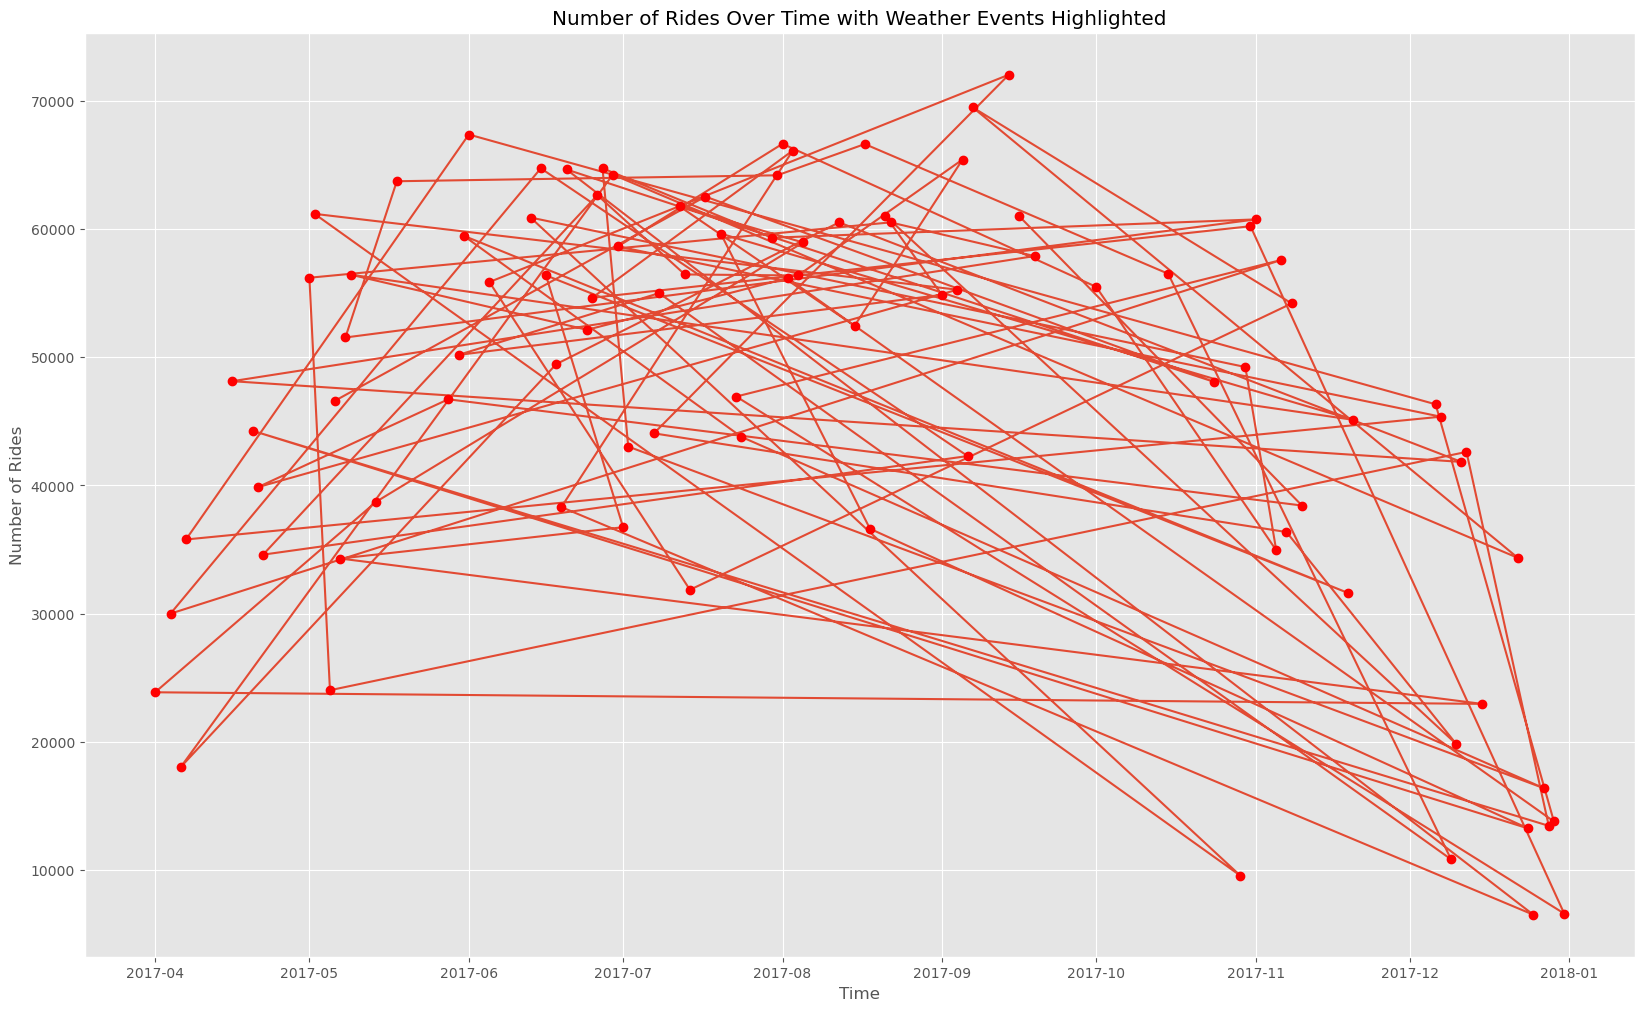

In [27]:
joined_df_pd = joined_df.select("*").toPandas()

# Filter out null values from the "day" column
joined_df_pd = joined_df_pd[joined_df_pd["day"].notnull()]

fig = plt.figure(figsize=(20, 12))

# Plot the number of rides over time
plt.plot(joined_df_pd["day"], joined_df_pd["count"])

# Add a dot for each row where the "event_types" column is not null
plt.plot(joined_df_pd.loc[joined_df_pd["event_types"].notnull(), "day"],
         joined_df_pd.loc[joined_df_pd["event_types"].notnull(), "count"],
         marker='o', linestyle='None', color='red')

plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.title("Number of Rides Over Time with Weather Events Highlighted")

plt.show()



Please note that the graph in the above cell would not format correctly in this notebook despite considerable time spent researching the issue. It formatted correctly in my individual EDA notebook. I have posted that image below.

![chart](https://i.imgur.com/byIQLdM.png)

<span style="font-size: 20px;">This graph explores the question "do drops in bike rentals correspond to reported bad weather events?" From the visuals we can see that sharp downward spikes in bike rentals have usually have a weather event reported on or near the day of the downward spike.</span>

# Predicting the next year's bike rentals
Using the data above, we can attempt to predict for the following year

In [29]:
# Import necessary functions
from pyspark.sql.functions import date_format, dayofyear
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Convert Pandas DataFrame to PySpark DataFrame
joined_df_sp = spark.createDataFrame(joined_df_pd)

# Format date in joined_df_sp
joined_df_sp = joined_df_sp.withColumn("day", dayofyear("date"))
joined_df_sp = joined_df_sp.withColumn("date", date_format("date", "yyyy-MM-dd"))

# Prepare data for clustering
assembler = VectorAssembler(inputCols=["count"], outputCol="features")
data = assembler.transform(joined_df_sp)

# Cluster data
kmeans = KMeans(k=4, seed=1)
model = kmeans.fit(data)

# Add predicted cluster column to the original dataframe
predictions = model.transform(data)
predictions = predictions.withColumn("date", date_format("date", "yyyy-MM-dd"))
joined_df_sp = joined_df_sp.join(predictions.select("date", "prediction"), "date")




23/05/01 01:06:39 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/01 01:06:39 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [30]:

# Show the predicted clusters for each day
joined_df_sp.select("date", "prediction").show()


+----------+----------+
|      date|prediction|
+----------+----------+
|2017-10-31|         0|
|2017-09-06|         2|
|2017-06-19|         2|
|2017-08-03|         0|
|2017-10-24|         3|
|2017-06-26|         0|
|2017-08-04|         3|
|2017-04-04|         2|
|2017-07-23|         2|
|2017-07-12|         0|
|2017-08-15|         3|
|2017-06-25|         3|
|2017-07-13|         3|
|2017-04-22|         2|
|2017-08-05|         0|
|2017-09-05|         0|
|2017-12-31|         1|
|2017-07-17|         0|
|2017-05-06|         2|
|2017-12-25|         1|
+----------+----------+
only showing top 20 rows



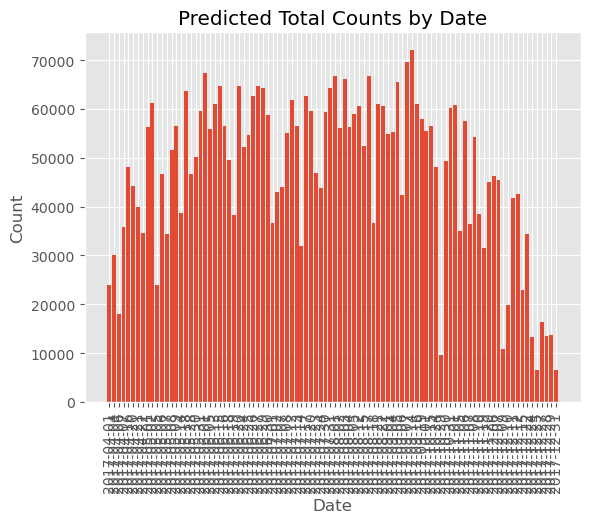

In [66]:
# Group the data by date and sum the counts for each day
counts_by_date = joined_df_sp.groupby("date").sum("count").orderBy("date").toPandas()

# Create the bar graph
plt.bar(counts_by_date["date"], counts_by_date["sum(count)"])
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Predicted Total Counts by Date")
plt.show()

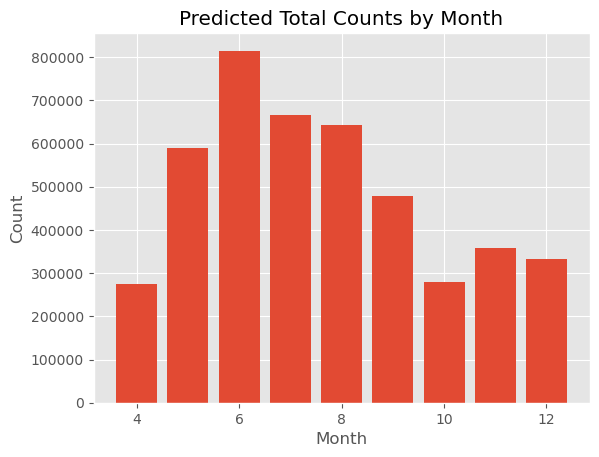

In [33]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import month

# Extract the month from the date column and sum the counts for each month
counts_by_month = joined_df_sp.groupBy(month("date").alias("month")).sum("count").orderBy("month").toPandas()

# Create the bar graph
plt.bar(counts_by_month["month"], counts_by_month["sum(count)"])
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Predicted Total Counts by Month")
plt.show()


### We use linear regression and group by month methodology to analyse how many bikes could be possibilly rented in the coming months. The above graph shows the same.